In [86]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression as LinearRegression
# Add the src directory t\ the Python path

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
# Now you can import the TimeSeriesDataset class
from src.TimeSeriesDataset import TimeSeriesDataset as TSD
from src.utils import download_data, weighted_mean
from src.mappings import value_mapping, ideology_mapping, social_complexity_mapping

Download datasets

In [87]:
dataset_PT = TSD(file_path='../datasets/power_transitions.xlsx')
dataset_PT.scv = dataset_PT.scv.groupby('dataset').get_group('PT')
dataset_PT.scv_imputed = dataset_PT.scv_imputed.groupby('dataset').get_group('PT')

dataset_FULL = TSD(file_path='../datasets/power_transitions.xlsx')
dataset_25y = TSD(file_path='../datasets/power_transitions.xlsx')
dataset_25y.scv = dataset_25y.scv.groupby('dataset').get_group('25y')
dataset_25y.scv_imputed = dataset_25y.scv_imputed.groupby('dataset').get_group('25y')

Dataset loaded from ../datasets/power_transitions.xlsx
Dataset loaded from ../datasets/power_transitions.xlsx
Dataset loaded from ../datasets/power_transitions.xlsx


impute MSP

In [88]:
religion_df = pd.read_excel('/Users/mperuzzo/Documents/repos/SeshatDatasetAnalysis/datasets/Polaris_data.xlsx',sheet_name='Religion')
dataset_PT.scv.MSP = dataset_PT.scv.PolityName.apply(lambda x: religion_df[religion_df.PolID == x].MSP.values[0] if x in religion_df.PolID.values else np.nan)
dataset_PT.scv_imputed['MSP'] = dataset_PT.scv_imputed.PolityName.apply(lambda x: religion_df[religion_df.PolID == x].MSP_imp.values[0] if x in religion_df.PolID.values else np.nan)

dataset_PT.scv_imputed['religion'] = dataset_PT.scv_imputed.PolityName.apply(lambda x: religion_df[religion_df.PolID == x].religion.values[0] if x in religion_df.PolID.values else np.nan)
dataset_PT.scv_imputed['religion_family'] = dataset_PT.scv_imputed.PolityName.apply(lambda x: religion_df[religion_df.PolID == x].RelFam.values[0] if x in religion_df.PolID.values else np.nan)
dataset_FULL.scv_imputed['MSP'] = dataset_FULL.scv_imputed.PolityName.apply(lambda x: religion_df[religion_df.PolID == x].MSP_imp.values[0] if x in religion_df.PolID.values else np.nan)

/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_90369/2006270674.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dataset_PT.scv.MSP = dataset_PT.scv.PolityName.apply(lambda x: religion_df[religion_df.PolID == x].MSP.values[0] if x in religion_df.PolID.values else np.nan)


Add crisis variables

In [89]:
crisis_vars = ['overturn',
              'predecessor_assassination'
              ,'intra_elite'
              ,'military_revolt'
              ,'popular_uprising'
              ,'separatist_rebellion'
              ,'external_invasion'
              ,'external_interference'
              ]
PT_mapping = {'PT_types':{}}
for col in crisis_vars:
    PT_mapping['PT_types'][col] = 1
    dataset_PT.scv[col] = dataset_PT.raw[col]
    dataset_PT.scv_imputed[col] = dataset_PT.scv[col]

dataset_PT.scv['Crisis'] = dataset_PT.raw.apply(lambda row: weighted_mean(row, PT_mapping, "PT_types", imputation='remove'), axis=1)
dataset_PT.scv_imputed['Crisis'] = dataset_PT.scv['Crisis']
dataset_PT.scv['duration'] = dataset_PT.raw['duration']
dataset_PT.scv_imputed['duration'] = dataset_PT.scv['duration']

Check for missing data

In [90]:
scale_cols = ['Pop','Terr','Cap']
non_scale_cols = ['Government', 'Infrastructure', 'Information', 'Money']
print(f"Missing rows in PT, total number of rows {len(dataset_PT.scv)}")
print('Missing rows in scale columns')
print(dataset_PT.scv_imputed[scale_cols].isna().any(axis=1).sum())
print("Missing rows in non-scale columns")
print(dataset_PT.scv_imputed[non_scale_cols].isna().any(axis=1).sum())
print("Missing rows in MSP")
print(dataset_PT.scv_imputed[['MSP']].isna().any(axis=1).sum())
print("Total not complete rows")
print(dataset_PT.scv_imputed[scale_cols+non_scale_cols+['MSP']].isna().any(axis=1).sum())

Missing rows in PT, total number of rows 3109
Missing rows in scale columns
1027
Missing rows in non-scale columns
341
Missing rows in MSP
5
Total not complete rows
1027


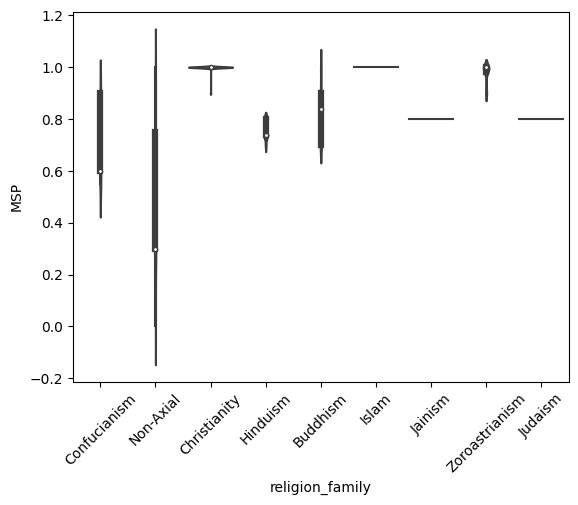

In [91]:
import seaborn as sns
sns.violinplot( data = dataset_PT.scv_imputed[['MSP', 'religion_family', 'Year']], x = 'religion_family', y = 'MSP')
# rotate x labels
plt.xticks(rotation=45)
plt.show()

In [92]:
comp_cols = ['Government', 'Infrastructure', 'Information', 'Money']
dataset_PT.scv_imputed['nScale'] = dataset_PT.scv_imputed[scale_cols].notna().sum(axis=1)
dataset_PT.scv_imputed['nComp'] = dataset_PT.scv_imputed[comp_cols].notna().sum(axis=1)

dataset_PT.scv_imputed = dataset_PT.scv_imputed.loc[dataset_PT.scv_imputed['nScale'] >2]
dataset_PT.scv_imputed = dataset_PT.scv_imputed.loc[dataset_PT.scv_imputed['nComp'] >2]

Compute scale and non-scale PCA

In [93]:
scale_cols = ['Pop','Terr','Cap']
scale_pca = dataset_25y.compute_PCA(cols = scale_cols, col_name = 'Scale', n_cols = 1, n_PCA= len(scale_cols))
dataset_PT.compute_PCA(cols = scale_cols, col_name = 'Scale', n_cols = 1, n_PCA= len(scale_cols), pca_func = scale_pca, contributions=True, rescale=True)
# rescale the PCA according to variable Pop
lm = sm.OLS(dataset_PT.scv_imputed['Scale_1'], dataset_PT.scv_imputed['Pop']).fit()


# Fit linear model to rescale the PCA according to variable Pop
lm_df = dataset_PT.scv_imputed[['Pop', 'Scale_1']].dropna()
X = lm_df[['Pop']]
y = lm_df['Scale_1']

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Extract the coefficients
intercept = model.intercept_
slope = model.coef_[0]

# Adjust the Scale_1 column
dataset_PT.scv_imputed['Scale_1'] = (dataset_PT.scv_imputed['Scale_1'] - intercept) / slope

there are some NaNs in the imputed dataset
Explained variance by each PC:
PC1: 90.16%
PC2: 7.20%
PC3: 2.64%
Explained variance by each PC:
PC1: 90.16%
PC2: 7.20%
PC3: 2.64%
PC1 contributions:
Pop: -0.59
Terr: -0.57
Cap: -0.57


In [94]:
inst_cols = ['Government', 'Infrastructure', 'Information', 'Money']
inst_pca = dataset_FULL.compute_PCA(cols = inst_cols, col_name = 'Inst', n_cols = 1, n_PCA= len(inst_cols))
dataset_PT.compute_PCA(cols = inst_cols, col_name = 'Inst', n_cols = 1, n_PCA= len(inst_cols), pca_func = inst_pca, contributions=True, rescale=True)
# dataset_PT.scv_imputed['Inst_1'] = -dataset_PT.scv_imputed['Inst_1']

there are some NaNs in the imputed dataset
Explained variance by each PC:
PC1: 68.71%
PC2: 15.10%
PC3: 9.69%
PC4: 6.50%
Explained variance by each PC:
PC1: 68.71%
PC2: 15.10%
PC3: 9.69%
PC4: 6.50%
PC1 contributions:
Government: -0.53
Infrastructure: -0.47
Information: -0.51
Money: -0.49


PCA(n_components=4)

In [95]:
# category_weight = [(d, len(social_complexity_mapping[d])) for d in social_complexity_mapping]
# dataset_PT.scv['Comp'] = 0
# dataset_PT.scv_imputed['Comp'] = 0
# for col in non_scale_cols:
#     dataset_PT.scv['Comp'] += dataset_PT.scv[col]*category_weight[non_scale_cols.index(col)][1]
#     dataset_PT.scv_imputed['Comp'] += dataset_PT.scv_imputed[col]*category_weight[non_scale_cols.index(col)][1]
# dataset_PT.scv['Comp'] = dataset_PT.scv['Comp']/30
# dataset_PT.scv_imputed['Comp'] = dataset_PT.scv_imputed['Comp']/30  
dataset_PT.scv_imputed['Comp'] = (dataset_PT.scv_imputed['Government']*11 + dataset_PT.scv_imputed['Infrastructure']*12 + dataset_PT.scv_imputed['Information']*13 + dataset_PT.scv_imputed['Money']*6)/(11+13+12+6)


In [96]:
dataset_PT.save_dataset('../datasets', 'PT_dataset_imputed')

Dataset saved to ../datasets/PT_dataset_imputed.xlsx


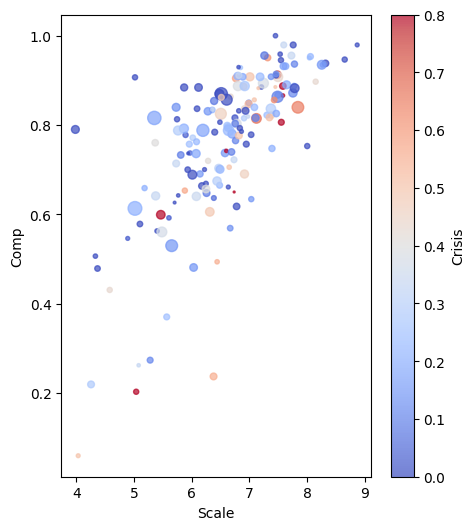

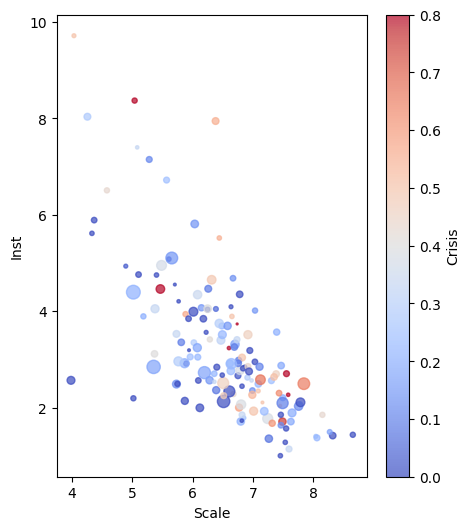

In [97]:
import matplotlib.pyplot as plt

dataset_plot = dataset_PT.scv_imputed
dataset_plot.sort_values('Crisis', inplace=True,ascending=True)
polity_group = dataset_PT.scv_imputed.groupby('PolityName')
fig, ax = plt.subplots(figsize=(5, 6))
# Assuming polity_group is a DataFrame or GroupBy object
mean_inst_1 = polity_group['Comp'].mean()
mean_scale_1 = polity_group['Scale_1'].mean()
mean_crisis = polity_group['predecessor_assassination'].mean()
num_observations = polity_group.size()

threshold = 0.
if threshold > 0:
    mean_inst_1 = mean_inst_1.loc[mean_crisis > threshold]
    mean_scale_1 = mean_scale_1.loc[mean_crisis > threshold]
    num_observations = num_observations[mean_crisis > threshold]
    mean_crisis = mean_crisis.loc[mean_crisis > threshold]


v_max = mean_crisis.max()*0.8
# Create a scatter plot
scatter = plt.scatter(mean_scale_1, mean_inst_1,
                      vmin = 0,
                      vmax = v_max,
                      c=mean_crisis,
                      cmap='coolwarm',
                      s=num_observations * 2,
                      alpha=0.7,
                      edgecolors=plt.cm.coolwarm(mean_crisis / v_max)
                      )

# Add a color bar
plt.colorbar(scatter, label='Crisis')
# add name of polity on each bubble

# Show the plot
# plt.title(crisis_vars)
plt.ylabel('Comp')
plt.xlabel('Scale')
plt.show()


dataset_plot = dataset_PT.scv_imputed
# dataset_plot = dataset_plot.loc[(dataset_plot.predecessor_assassination > 0) | (dataset_plot.Crisis == 0)]
dataset_plot.sort_values('Crisis', inplace=True,ascending=True)
polity_group = dataset_PT.scv_imputed.groupby('PolityName')
fig, ax = plt.subplots(figsize=(5, 6))
# Assuming polity_group is a DataFrame or GroupBy object
mean_inst_1 = polity_group['Inst_1'].mean()
mean_scale_1 = polity_group['Scale_1'].mean()
mean_crisis = polity_group['predecessor_assassination'].mean()
num_observations = polity_group.size()

threshold = 0.
if threshold > 0:
    mean_inst_1 = mean_inst_1.loc[mean_crisis > threshold]
    mean_scale_1 = mean_scale_1.loc[mean_crisis > threshold]
    num_observations = num_observations[mean_crisis > threshold]
    mean_crisis = mean_crisis.loc[mean_crisis > threshold]


v_max = mean_crisis.max()*0.8
# Create a scatter plot
scatter = plt.scatter(mean_scale_1, mean_inst_1,
                      vmin = 0,
                      vmax = v_max,
                      c=mean_crisis,
                      cmap='coolwarm',
                      s=num_observations * 2,
                      alpha=0.7,
                      edgecolors=plt.cm.coolwarm(mean_crisis / v_max)
                      )

# Add a color bar
plt.colorbar(scatter, label='Crisis')
# add name of polity on each bubble

# Show the plot
# plt.title(crisis_vars)
plt.ylabel('Inst')
plt.xlabel('Scale')
plt.show()



In [99]:
# fit to linear regressor 
x_cols = ['Scale_1', 'Comp']
y_col = 'predecessor_assassination'
# rel_rows = dataset_PT.scv_imputed.apply(lambda row: (row.Crisis == 0) | (row[[y_col]]>0), axis=1)[[y_col]].values
Xy = dataset_PT.scv_imputed
Xy = Xy[[y_col]+x_cols].dropna()

Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
y = Xy[y_col]

linear_model = sm.OLS(y, X)
result = linear_model.fit()
print(result.summary())

logit_model = sm.Logit(y, X)
result = logit_model.fit()

print(result.summary())



# for religion in dataset_PT.scv_imputed.religion_family.unique():
#     Xy = dataset_PT.scv_imputed.loc[dataset_PT.scv_imputed.religion_family == religion]
#     Xy = Xy[[y_col]+x_cols].dropna()
#     if len(Xy) < 10:
#         continue
#     print(f"\nReligion {religion}, number of observations {len(Xy)}\n")
#     Xy[x_cols] = (Xy[x_cols] - Xy[x_cols].mean())/Xy[x_cols].std()
#     Xy['intercept'] = 1
#     X = Xy[x_cols+ ['intercept']]
#     y = Xy[y_col].apply(int)

#     logit_model = sm.Logit(y, X)
#     result = logit_model.fit()

#     print(result.summary())

# plt.scatter(Xy['Scale_1'], Xy['Comp'], c=Xy['predecessor_assassination'], s = 6, alpha=1)

                                OLS Regression Results                               
Dep. Variable:     predecessor_assassination   R-squared:                       0.029
Model:                                   OLS   Adj. R-squared:                  0.023
Method:                        Least Squares   F-statistic:                     4.457
Date:                       Thu, 30 Jan 2025   Prob (F-statistic):             0.0124
Time:                               15:18:18   Log-Likelihood:                -138.66
No. Observations:                        300   AIC:                             283.3
Df Residuals:                            297   BIC:                             294.4
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

In [100]:
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

def partial_correlation(x, y, z):
    """
    Calculate the partial correlation between x and y, controlling for z.

    Parameters:
        x, y, z: numpy arrays of the same length.

    Returns:
        Partial correlation coefficient and p-value.
    """
    # Reshape z for regression
    z = z.reshape(-1, 1) if z.ndim == 1 else z
    
    # Regress x on z
    model_xz = LinearRegression().fit(z, x)
    residual_x = x - model_xz.predict(z)
    
    # Regress y on z
    model_yz = LinearRegression().fit(z, y)
    residual_y = y - model_yz.predict(z)
    
    # Calculate correlation between residuals
    r, p_value = pearsonr(residual_x, residual_y)
    
    return r, p_value


# Generate some example data
x = Xy[x_cols[0]].values
x = (x - x.mean())/x.std()
y = Xy[y_col].values
y = (y - y.mean())/y.std()
z = Xy[x_cols[1]].values

# Partial correlation between x and y, controlling for z
r, p = partial_correlation(x, y, z)
print(f"Partial Correlation: {r:.5f}, p-value: {p}")

# Generate some example data
x = Xy[x_cols[1]].values
y = Xy[y_col].values
z = Xy[x_cols[0]].values

# Partial correlation between x and y, controlling for z
r, p = partial_correlation(x, y, z)
print(f"Partial Correlation: {r:.5f}, p-value: {p}")


Partial Correlation: 0.13067, p-value: 0.023601698008949946
Partial Correlation: -0.16918, p-value: 0.003289094506830558


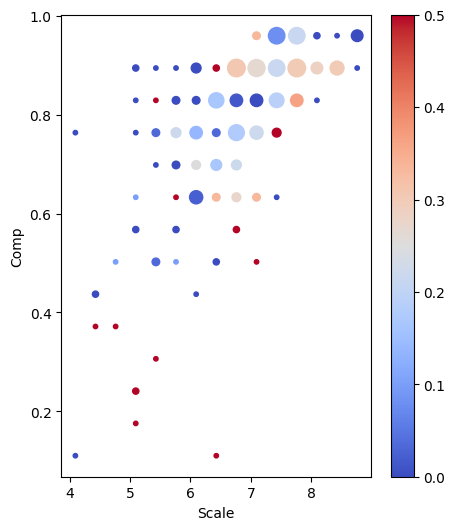

In [101]:
x = Xy[x_cols[0]].values
y = Xy[x_cols[1]].values
z = Xy[y_col].values

grid_size = 15

df = pd.DataFrame({'x': x, 'y': y, 'z': z})

# Define the grid
x_bins = np.linspace(min(x), max(x), grid_size + 1)
y_bins = np.linspace(min(y), max(y), grid_size + 1)

# Bin the data
df['x_bin'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)
df['y_bin'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)

x_bins = np.linspace(df.loc[df.x_bin == df.x_bin.min(),'x'].mean(),df.loc[df.x_bin == df.x_bin.max(),'x'].mean(), len(df.x_bin.unique()))
y_bins = np.linspace(df.loc[df.y_bin == df.y_bin.min(),'y'].mean(),df.loc[df.y_bin == df.y_bin.max(),'y'].mean(), len(df.y_bin.unique()))

# Group by the bins and calculate the mean of z
grid = df.groupby(['x_bin', 'y_bin'])['z'].mean().unstack()
grid_std = df.groupby(['x_bin', 'y_bin'])['z'].std().unstack()
counts = df.groupby(['x_bin', 'y_bin'])['z'].count().unstack()

fig, ax = plt.subplots(figsize=(5, 6))
x,y = np.meshgrid(x_bins, y_bins)
plt.scatter(x.flatten(), y.flatten(), c=grid.T.values.flatten(), cmap='coolwarm', s=10*counts.T.values.flatten(), vmax = 0.5)
plt.colorbar()
plt.xlabel('Scale')
plt.ylabel('Comp')
# plt.title(crisis_vars)
plt.show()

In [130]:
print(len(dataset_FULL.scv.drop_duplicates(subset=scale_cols+non_scale_cols+['dataset'])))
print(len(dataset_25y.scv.drop_duplicates(subset=scale_cols+non_scale_cols+['dataset'])))

1140
707


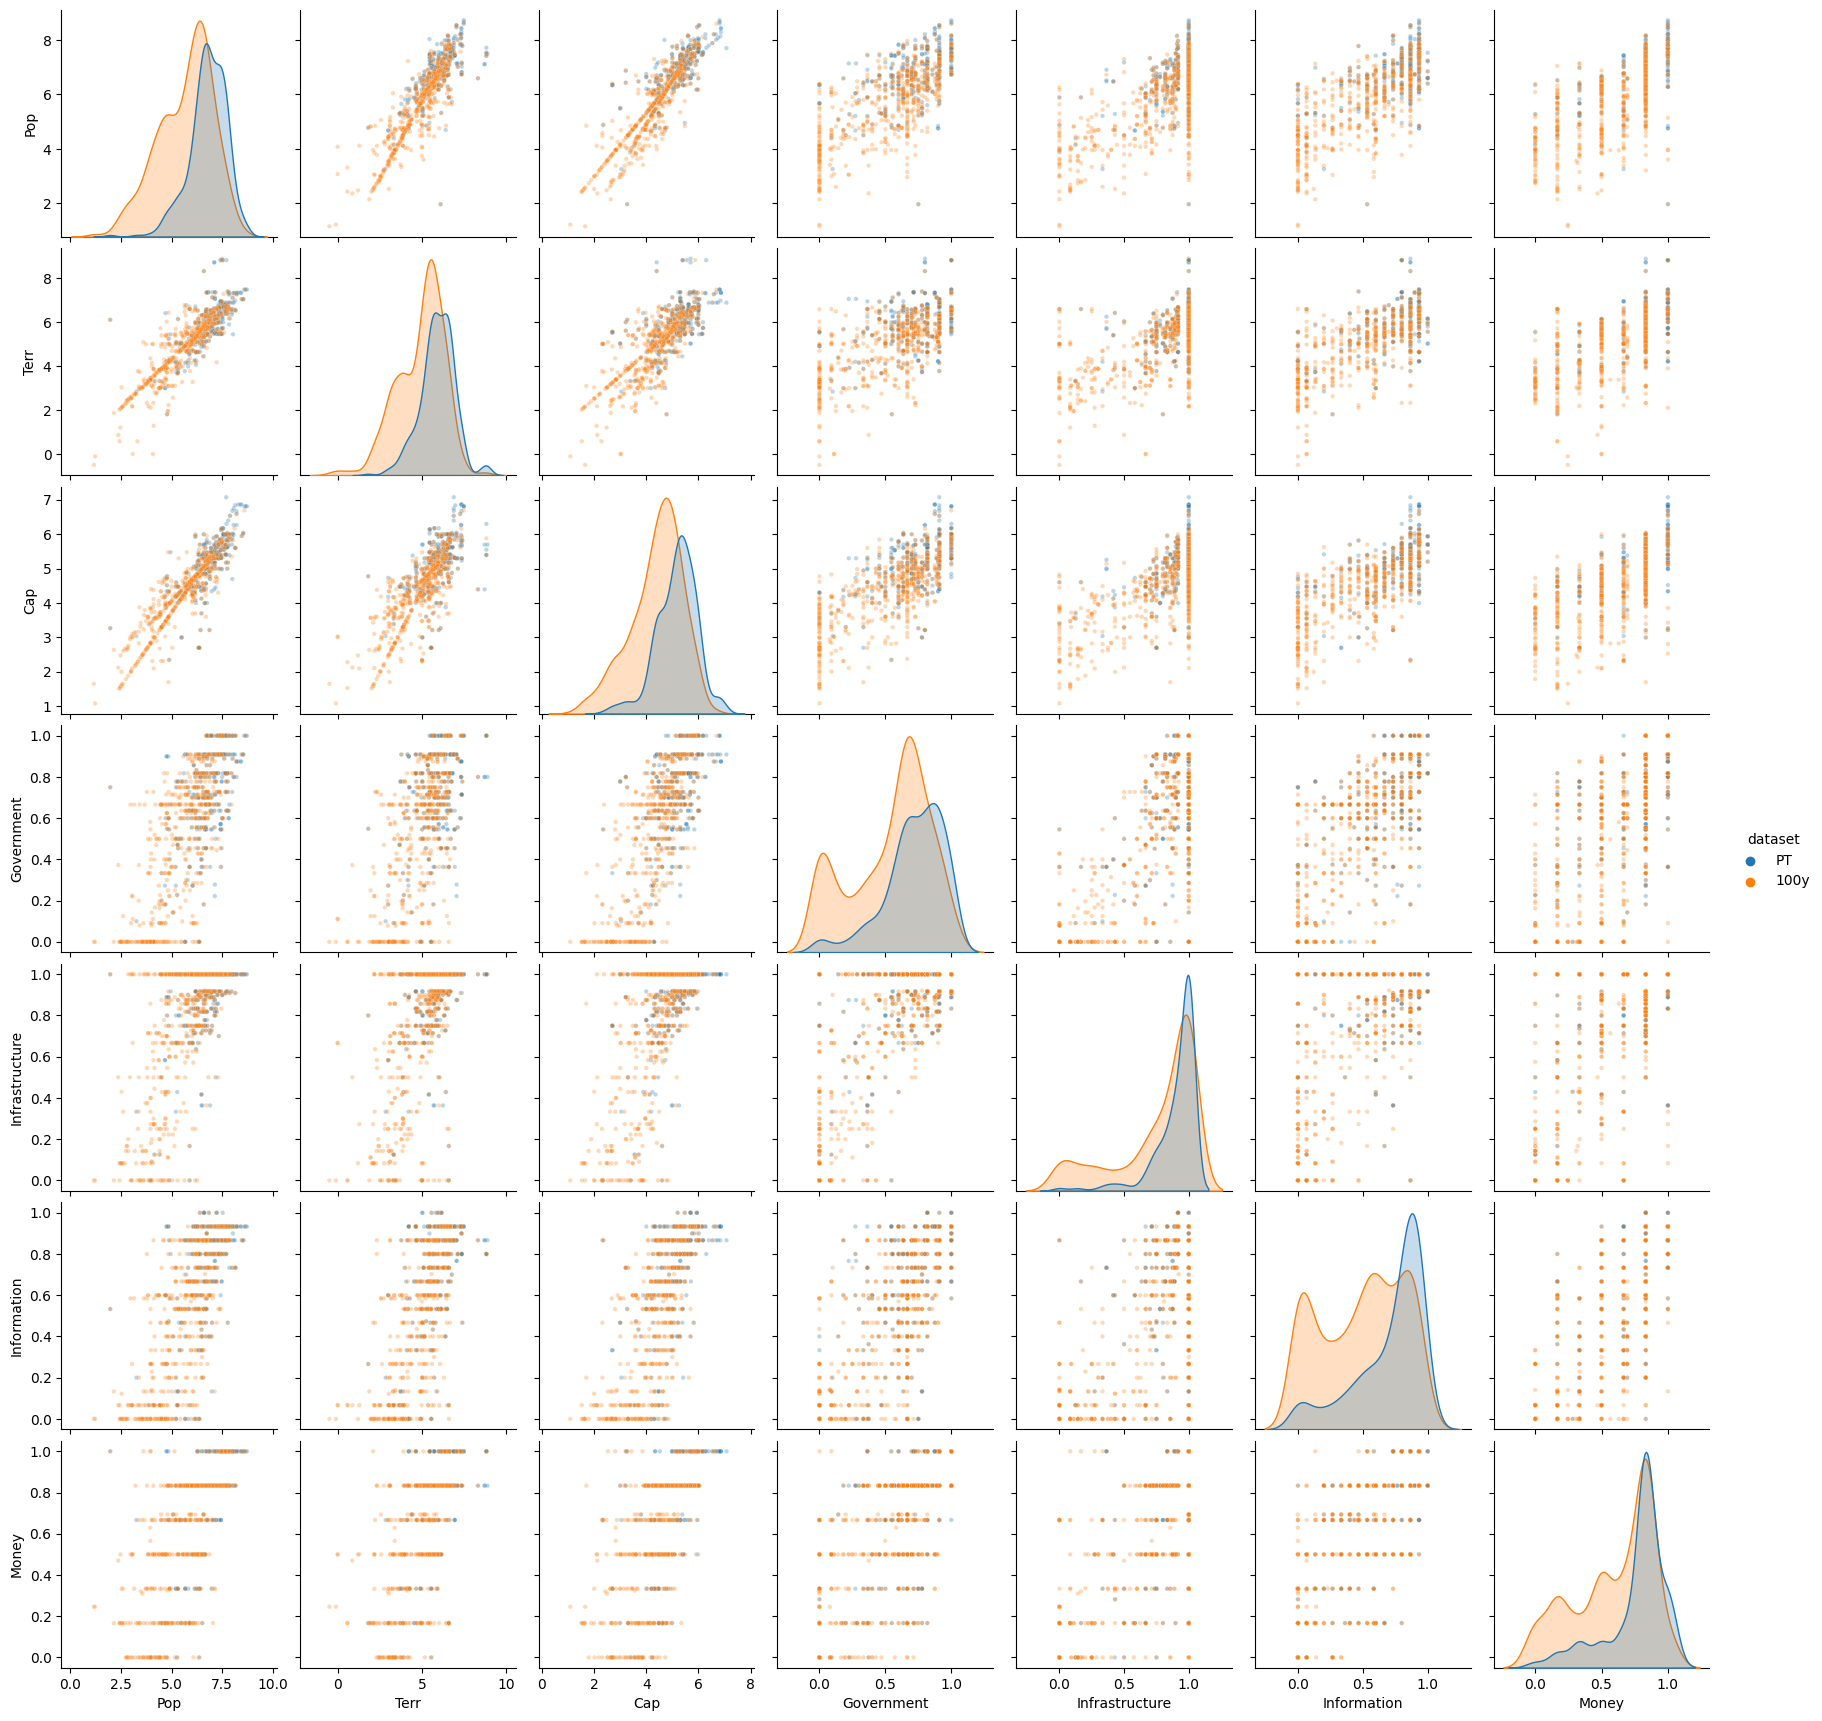

In [131]:
import seaborn as sns
plot_df = dataset_FULL.scv_imputed.drop_duplicates(subset=scale_cols+non_scale_cols+['dataset'])
plot_df.loc[plot_df.dataset == '25y','dataset'] = '100y'

sns.pairplot(plot_df[scale_cols+non_scale_cols+['dataset']], hue='dataset', plot_kws={'alpha': 0.3, 's': 10})

In [77]:
succ_df = download_data('https://seshat-db.com/api/general/polity-succeeding-entities')
polity_df = download_data('https://seshat-db.com/api/core/polities')
succ_df_remove = succ_df.copy()
succ_df_remove = succ_df_remove.sort_values('polity_start_year')
succ_df_remove.reset_index(drop=True, inplace=True)
threads = []

while len(succ_df_remove) > 0:
    new_thread = []
    polity = succ_df_remove.iloc[0]
    while True:
        new_thread.append(polity.polity_new_name)
        pol_name = polity_df.loc[polity_df.long_name == polity.succeeding_entity, 'new_name']
        if len(pol_name) == 0:
            succ_df_remove.drop(0, inplace=True)
            succ_df_remove.reset_index(drop=True, inplace=True)
            break
        pol_name = pol_name.iloc[0]
        print(pol_name)
        succ_df_remove.drop(0, inplace=True)
        succ_df_remove.reset_index(drop=True, inplace=True)
        polity = succ_df_remove[succ_df_remove.polity_new_name == pol_name]
        if len(polity) == 0:
            break
        polity = polity.iloc[0]

    print(len(succ_df_remove))

    if len(new_thread) > 3:
        threads.append(new_thread)

Downloaded 458 rows
Downloaded 863 rows
jp_jomon_2
456
455
ir_susiana_formative
453
452
gr_crete_pre_palace
450
tr_konya_lnl
448
ir_susiana_b
ir_susiana_ubaid_1
ir_susiana_ubaid_2
ir_susa_1
ir_susa_2
ir_susa_3
ir_elam_1
iq_akkad_emp
439
cn_longshan
cn_erlitou
cn_erligang
cn_late_shang_dyn
cn_western_zhou_dyn
433
eg_naqada_2
eg_naqada_3
eg_dynasty_1
eg_dynasty_2
eg_old_k_1
eg_old_k_2
eg_regions
eg_middle_k
eg_thebes_hyksos
eg_new_k_1
422
421
420
cn_erlitou
cn_erligang
cn_late_shang_dyn
cn_western_zhou_dyn
415
eg_old_k_2
eg_regions
eg_middle_k
eg_thebes_hyksos
eg_new_k_1
409
eg_middle_k
eg_thebes_hyksos
eg_new_k_1
405
eg_thebes_hyksos
eg_new_k_1
402
401
400
399
ir_elam_4
ir_elam_5
iq_neo_assyrian_emp
396
395
it_latium_ia
it_roman_k
it_roman_rep_1
it_roman_rep_2
it_roman_rep_3
it_roman_principate
tr_roman_dominate
it_western_roman_emp
386
iq_neo_assyrian_emp
385
384
tr_hatti_new_k
tr_neo_hittite_k
tr_tabal_k
380
mn_hunnu_emp
378
iq_neo_assyrian_emp
377
ir_achaemenid_emp
gr_macedonian_emp


['ir_susiana_a', 'ir_susiana_b', 'ir_susiana_ubaid_1', 'ir_susiana_ubaid_2', 'ir_susa_1', 'ir_susa_2', 'ir_susa_3', 'ir_elam_1', 'iq_akkad_emp']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_90369/2174842325.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Inst_1', 'Scale_1'], inplace=True)


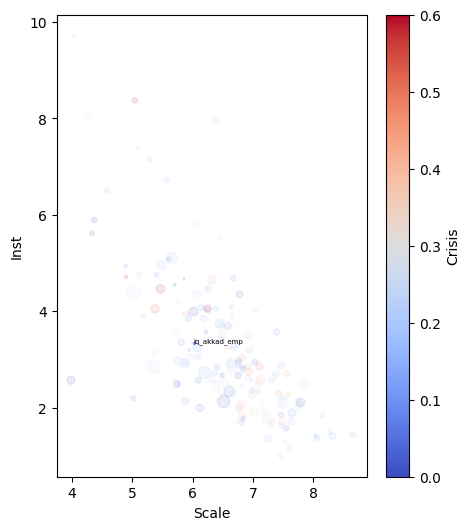

['cn_yangshao', 'cn_longshan', 'cn_erlitou', 'cn_erligang', 'cn_late_shang_dyn', 'cn_western_zhou_dyn']
['eg_naqada_1', 'eg_naqada_2', 'eg_naqada_3', 'eg_dynasty_1', 'eg_dynasty_2', 'eg_old_k_1', 'eg_old_k_2', 'eg_regions', 'eg_middle_k', 'eg_thebes_hyksos', 'eg_new_k_1']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_90369/2174842325.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Inst_1', 'Scale_1'], inplace=True)
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_90369/2174842325.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Inst_1', 'Scale_1'], inplace=True)


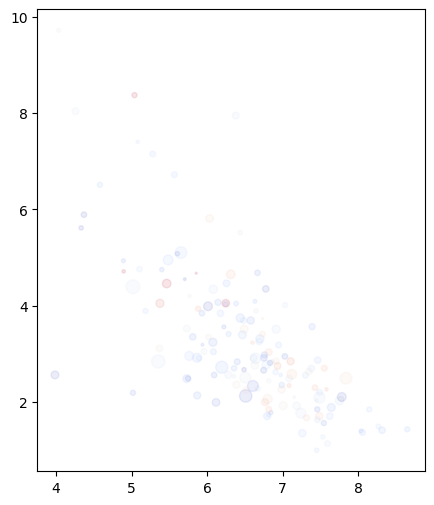

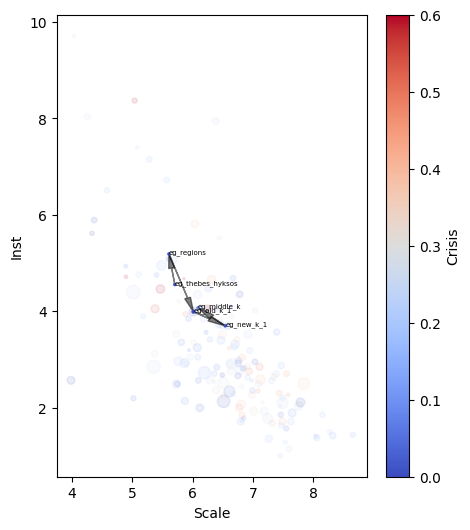

['cn_longshan', 'cn_erlitou', 'cn_erligang', 'cn_late_shang_dyn', 'cn_western_zhou_dyn']
['eg_old_k_1', 'eg_old_k_2', 'eg_regions', 'eg_middle_k', 'eg_thebes_hyksos', 'eg_new_k_1']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_90369/2174842325.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Inst_1', 'Scale_1'], inplace=True)
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_90369/2174842325.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Inst_1', 'Scale_1'], inplace=True)


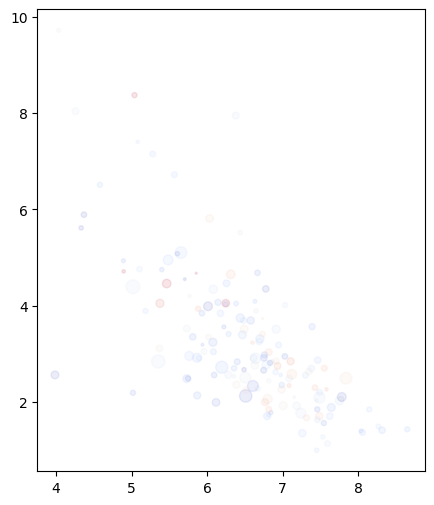

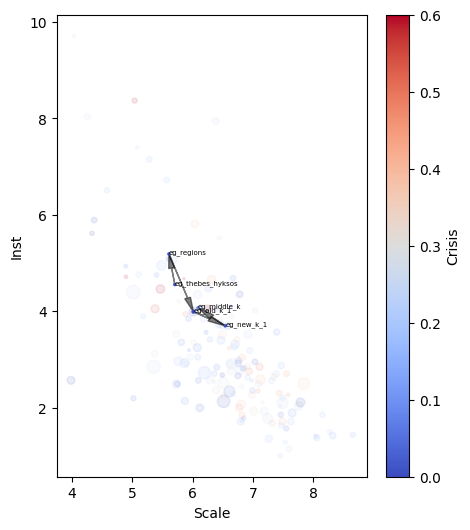

['eg_regions', 'eg_middle_k', 'eg_thebes_hyksos', 'eg_new_k_1']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_90369/2174842325.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Inst_1', 'Scale_1'], inplace=True)


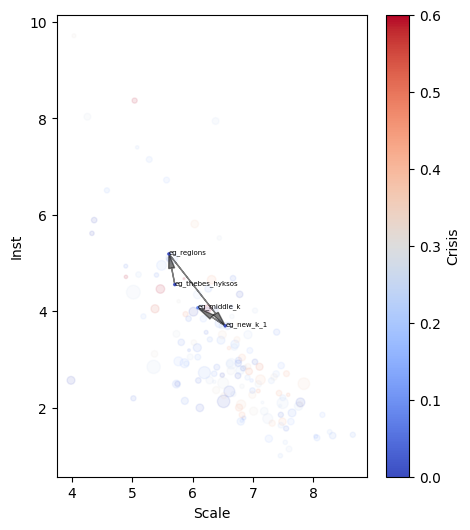

['it_latium_ba', 'it_latium_ia', 'it_roman_k', 'it_roman_rep_1', 'it_roman_rep_2', 'it_roman_rep_3', 'it_roman_principate', 'tr_roman_dominate', 'it_western_roman_emp']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_90369/2174842325.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Inst_1', 'Scale_1'], inplace=True)


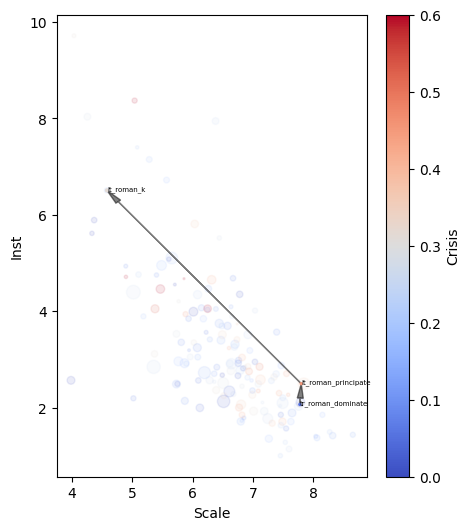

['tr_konya_lba', 'tr_hatti_new_k', 'tr_neo_hittite_k', 'tr_tabal_k']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_90369/2174842325.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Inst_1', 'Scale_1'], inplace=True)


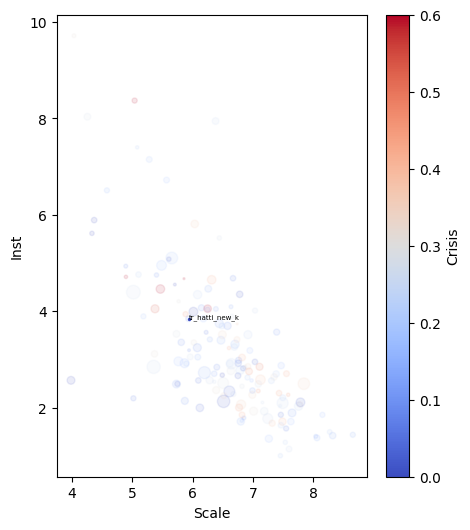

['gr_crete_geometric', 'gr_crete_archaic', 'gr_crete_classical', 'gr_crete_hellenistic']
['fr_hallstatt_b2_3', 'fr_hallstatt_c', 'fr_hallstatt_d', 'fr_la_tene_a_b1', 'fr_la_tene_b2_c1', 'fr_la_tene_c2_d', 'it_roman_rep_3', 'it_roman_principate', 'tr_roman_dominate', 'it_western_roman_emp']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_90369/2174842325.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Inst_1', 'Scale_1'], inplace=True)
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_90369/2174842325.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Inst_1', 'Scale_1'], inplace=True)


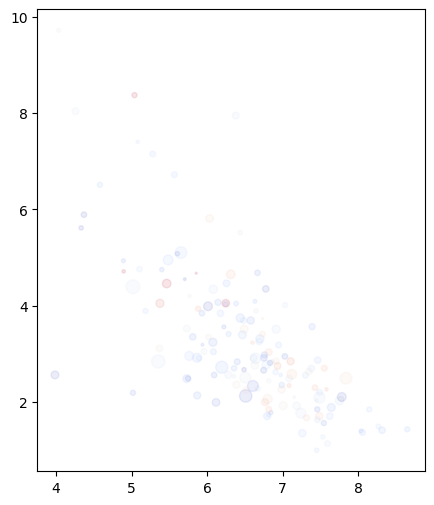

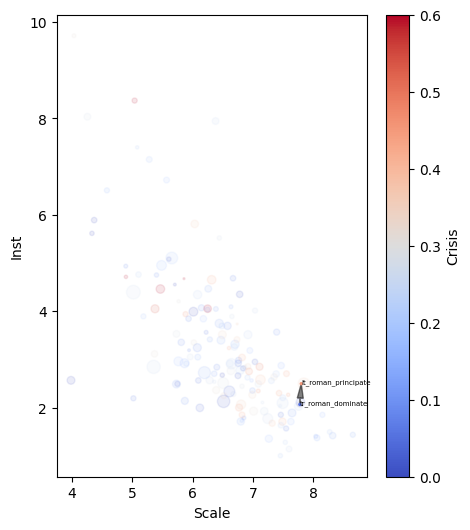

['it_roman_k', 'it_roman_rep_1', 'it_roman_rep_2', 'it_roman_rep_3', 'it_roman_principate', 'tr_roman_dominate', 'it_western_roman_emp']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_90369/2174842325.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Inst_1', 'Scale_1'], inplace=True)


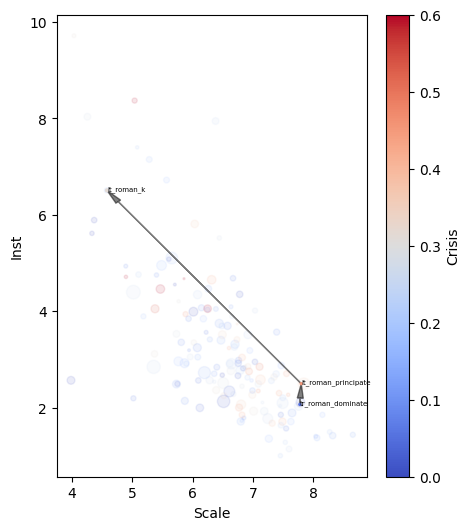

['us_woodland_1', 'us_woodland_2', 'us_woodland_3', 'us_woodland_4', 'us_woodland_5', 'us_emergent_mississippian_1']
['fr_la_tene_a_b1', 'fr_la_tene_b2_c1', 'fr_la_tene_c2_d', 'it_roman_rep_3', 'it_roman_principate', 'tr_roman_dominate', 'it_western_roman_emp']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_90369/2174842325.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Inst_1', 'Scale_1'], inplace=True)
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_90369/2174842325.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Inst_1', 'Scale_1'], inplace=True)


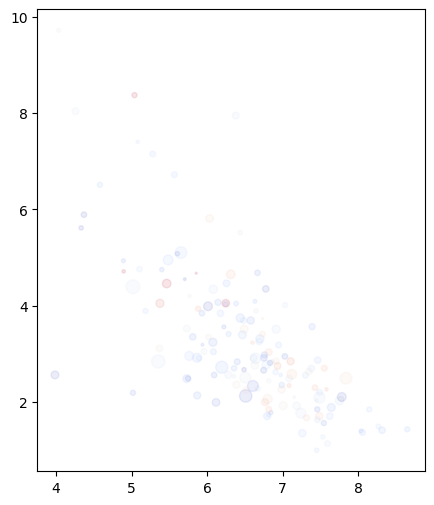

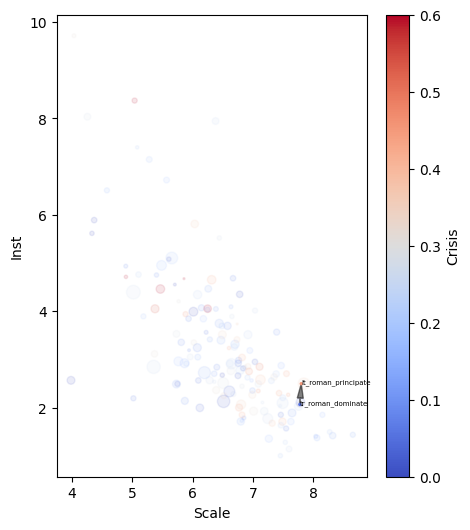

['fr_la_tene_b2_c1', 'fr_la_tene_c2_d', 'it_roman_rep_3', 'it_roman_principate', 'tr_roman_dominate', 'it_western_roman_emp']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_90369/2174842325.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Inst_1', 'Scale_1'], inplace=True)


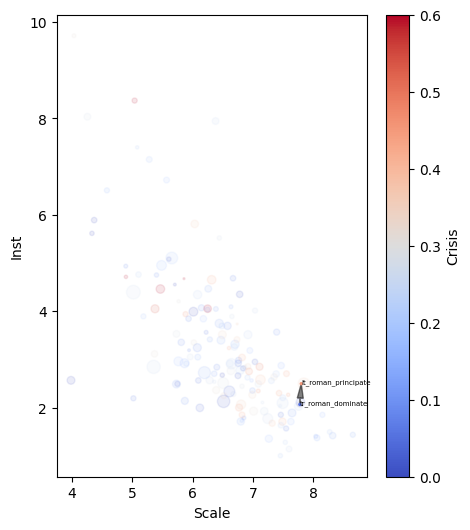

['sl_anuradhapura_1', 'sl_anuradhapura_2', 'sl_anuradhapura_3', 'sl_anuradhapura_4']
['it_roman_rep_2', 'it_roman_rep_3', 'it_roman_principate', 'tr_roman_dominate', 'it_western_roman_emp']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_90369/2174842325.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Inst_1', 'Scale_1'], inplace=True)
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_90369/2174842325.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Inst_1', 'Scale_1'], inplace=True)


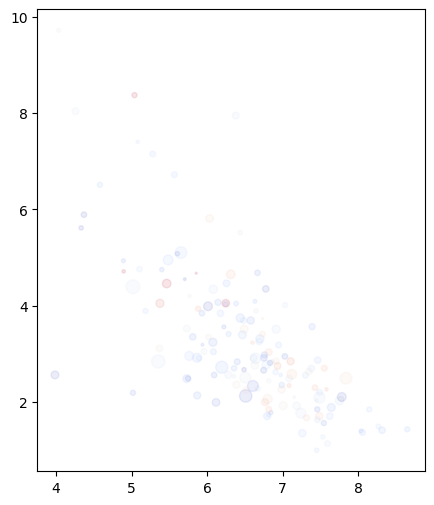

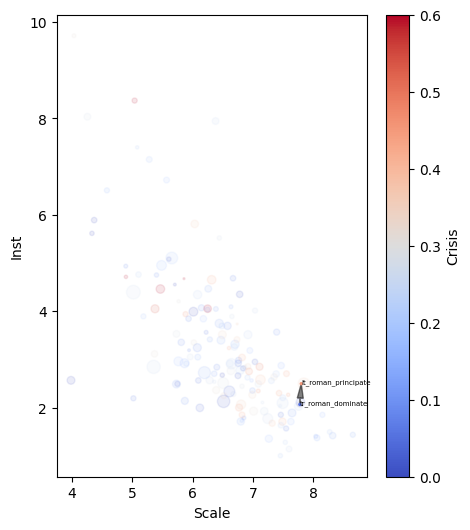

['fr_la_tene_c2_d', 'it_roman_rep_3', 'it_roman_principate', 'tr_roman_dominate', 'it_western_roman_emp']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_90369/2174842325.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Inst_1', 'Scale_1'], inplace=True)


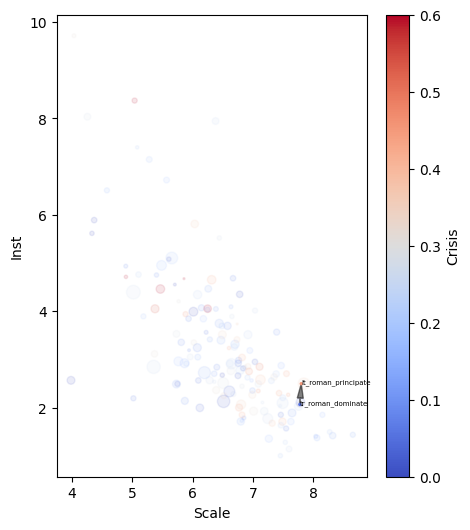

['tr_east_roman_emp', 'tr_byzantine_emp_1', 'tr_byzantine_emp_2', 'tr_byzantine_emp_3']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_90369/2174842325.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Inst_1', 'Scale_1'], inplace=True)


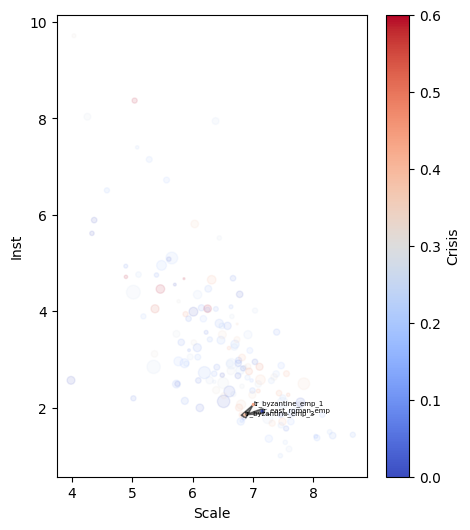

['fr_merovingian_emp_1', 'fr_merovingian_emp_2', 'fr_merovingian_emp_3', 'fr_carolingian_emp_1', 'fr_carolingian_emp_2', 'fr_capetian_k_1', 'fr_capetian_k_2', 'fr_valois_k_1', 'fr_valois_k_2', 'fr_bourbon_k_1', 'fr_bourbon_k_2']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_90369/2174842325.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Inst_1', 'Scale_1'], inplace=True)


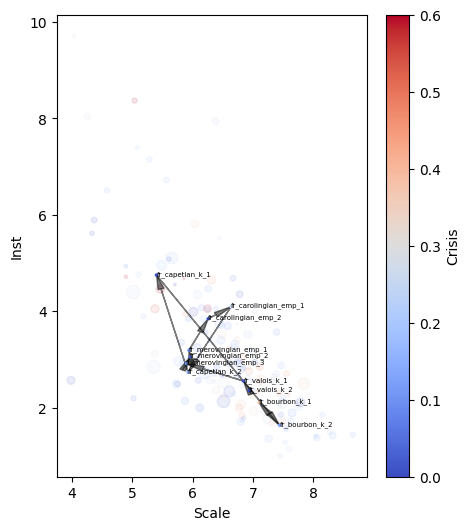

['kg_western_turk_khaganate', 'uz_sogdiana_city_states', 'sy_umayyad_cal', 'iq_abbasid_cal_1', 'ir_buyid_confederation']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_90369/2174842325.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Inst_1', 'Scale_1'], inplace=True)


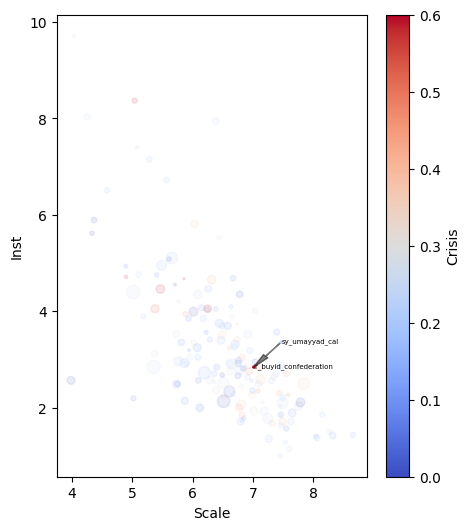

/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_90369/2174842325.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Inst_1', 'Scale_1'], inplace=True)


['uz_sogdiana_city_states', 'sy_umayyad_cal', 'iq_abbasid_cal_1', 'ir_buyid_confederation']


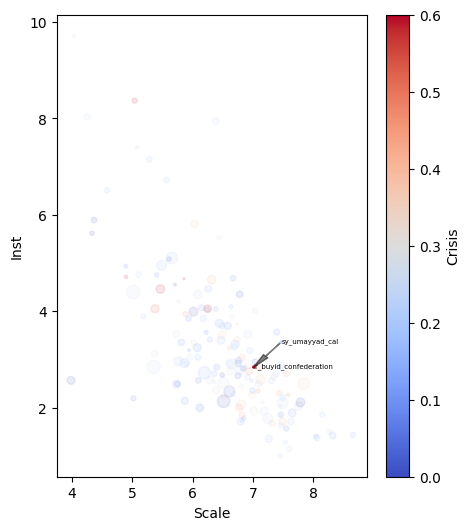

['fr_merovingian_emp_3', 'fr_carolingian_emp_1', 'fr_carolingian_emp_2', 'fr_capetian_k_1', 'fr_capetian_k_2', 'fr_valois_k_1', 'fr_valois_k_2', 'fr_bourbon_k_1', 'fr_bourbon_k_2']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_90369/2174842325.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Inst_1', 'Scale_1'], inplace=True)


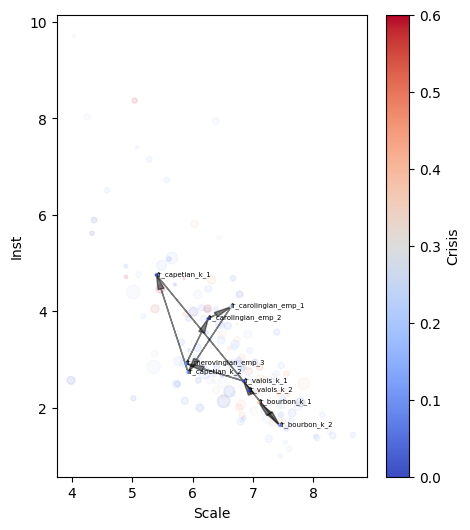

['fr_carolingian_emp_1', 'fr_carolingian_emp_2', 'fr_capetian_k_1', 'fr_capetian_k_2', 'fr_valois_k_1', 'fr_valois_k_2', 'fr_bourbon_k_1', 'fr_bourbon_k_2']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_90369/2174842325.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Inst_1', 'Scale_1'], inplace=True)


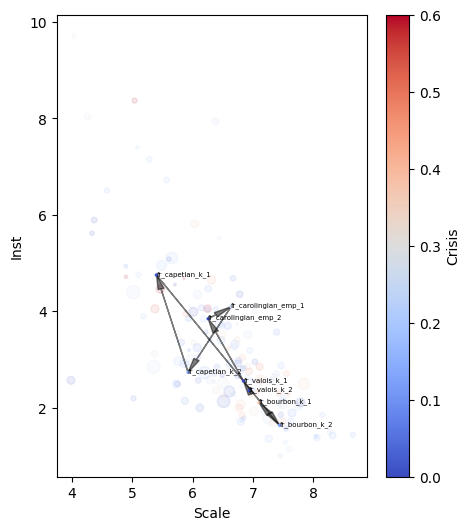

['fr_carolingian_emp_2', 'fr_capetian_k_1', 'fr_capetian_k_2', 'fr_valois_k_1', 'fr_valois_k_2', 'fr_bourbon_k_1', 'fr_bourbon_k_2']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_90369/2174842325.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Inst_1', 'Scale_1'], inplace=True)


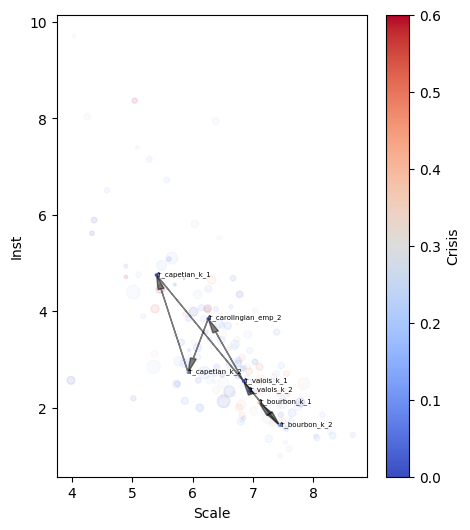

['mn_khitan_1', 'mn_mongol_early', 'mn_mongol_emp', 'cn_yuan_dyn']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_90369/2174842325.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Inst_1', 'Scale_1'], inplace=True)


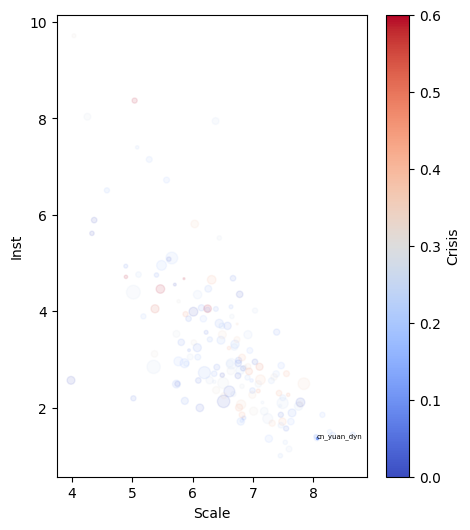

['fr_capetian_k_1', 'fr_capetian_k_2', 'fr_valois_k_1', 'fr_valois_k_2', 'fr_bourbon_k_1', 'fr_bourbon_k_2']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_90369/2174842325.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Inst_1', 'Scale_1'], inplace=True)


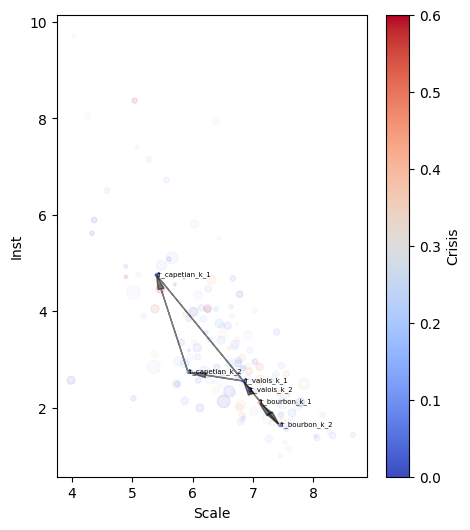

['us_cahokia_1', 'us_cahokia_2', 'us_cahokia_3', 'us_oneota', 'us_early_illinois_confederation']
['kh_angkor_2', 'kh_angkor_3', 'kh_khmer_k', 'th_ayutthaya', 'th_rattanakosin']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_90369/2174842325.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Inst_1', 'Scale_1'], inplace=True)
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_90369/2174842325.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Inst_1', 'Scale_1'], inplace=True)


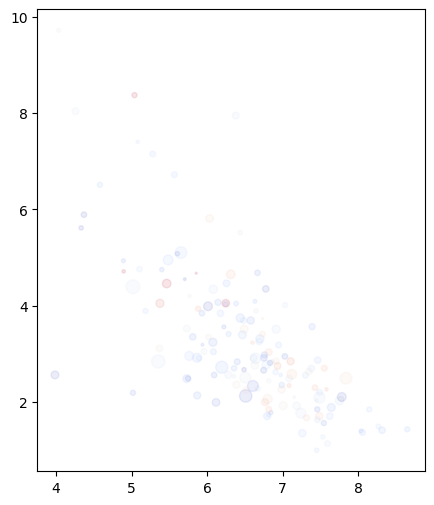

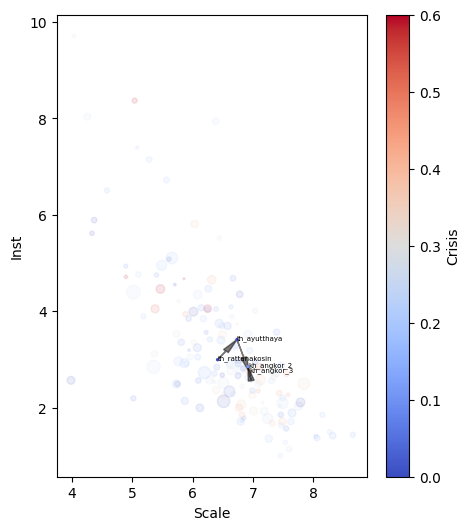

['fr_capetian_k_2', 'fr_valois_k_1', 'fr_valois_k_2', 'fr_bourbon_k_1', 'fr_bourbon_k_2']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_90369/2174842325.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Inst_1', 'Scale_1'], inplace=True)


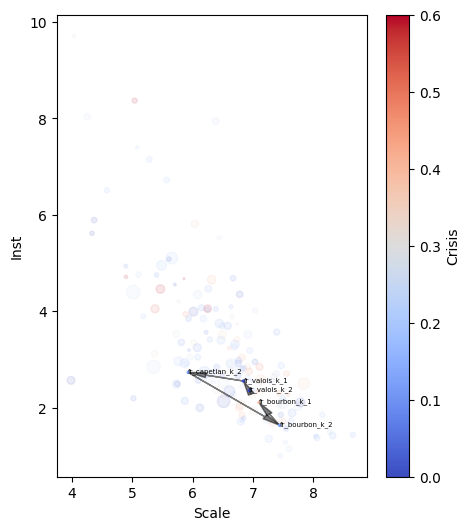

['us_cahokia_2', 'us_cahokia_3', 'us_oneota', 'us_early_illinois_confederation']
['kh_angkor_3', 'kh_khmer_k', 'th_ayutthaya', 'th_rattanakosin']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_90369/2174842325.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Inst_1', 'Scale_1'], inplace=True)
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_90369/2174842325.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Inst_1', 'Scale_1'], inplace=True)


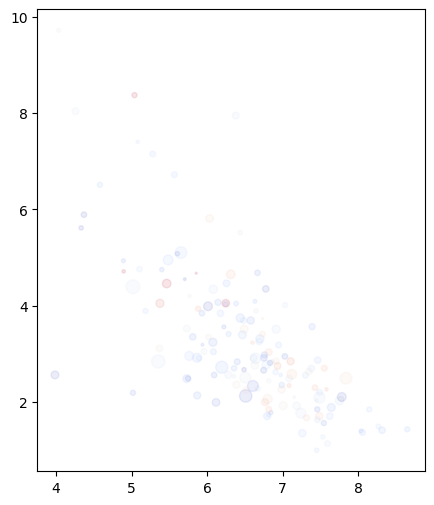

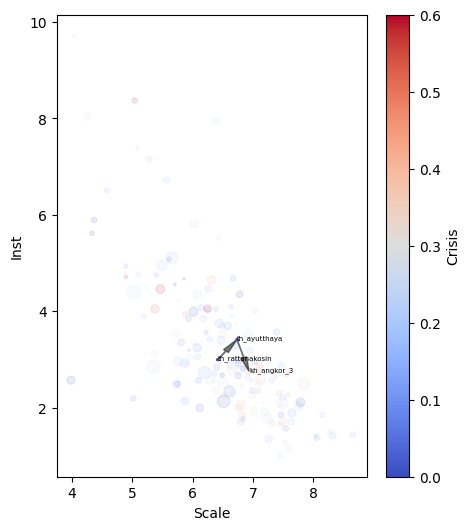

['eg_mamluk_sultanate_1', 'eg_mamluk_sultanate_2', 'eg_mamluk_sultanate_3', 'tr_ottoman_emp_2', 'tr_ottoman_emp_3']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_90369/2174842325.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Inst_1', 'Scale_1'], inplace=True)


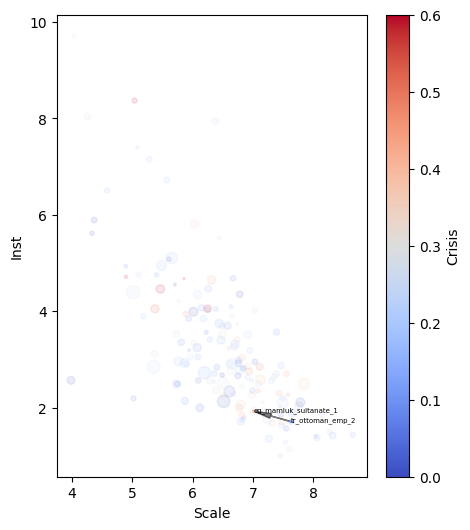

['in_kampili_k', 'in_vijayanagara_emp', 'in_mughal_emp', 'af_durrani_emp']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_90369/2174842325.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Inst_1', 'Scale_1'], inplace=True)


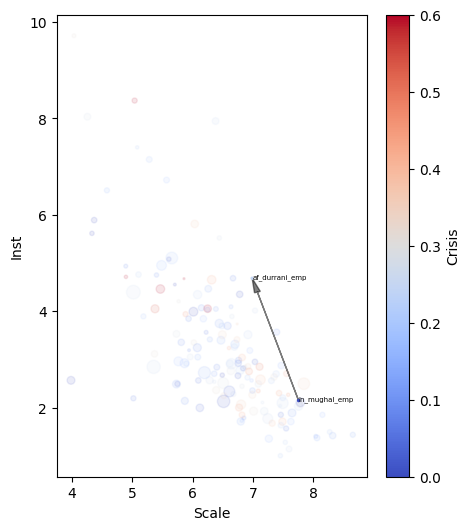

['tr_ottoman_emirate', 'tr_ottoman_emp_1', 'tr_ottoman_emp_2', 'tr_ottoman_emp_3']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_90369/2174842325.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Inst_1', 'Scale_1'], inplace=True)


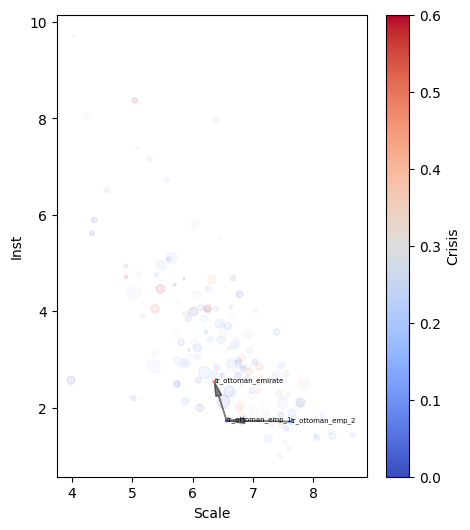

['fr_valois_k_1', 'fr_valois_k_2', 'fr_bourbon_k_1', 'fr_bourbon_k_2']


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_90369/2174842325.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_df.dropna(subset=['Inst_1', 'Scale_1'], inplace=True)


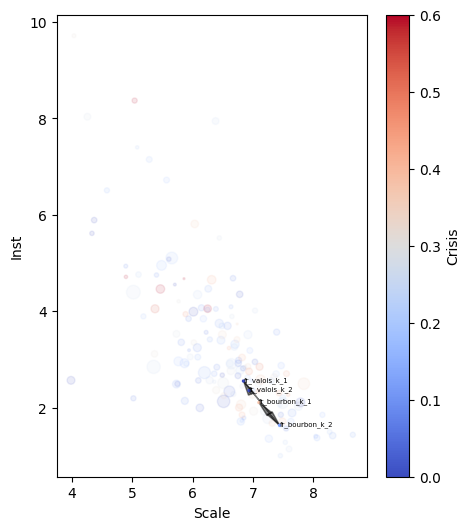

In [78]:
NGAs = dataset_PT.scv_imputed['NGA'].unique()

for thread in threads:
    if len(thread) < 3:
        continue
    print(thread)

    dataset_plot = dataset_PT.scv_imputed
    dataset_plot.sort_values('Crisis', inplace=True,ascending=True)
    polity_group = dataset_PT.scv_imputed.groupby('PolityName')
    fig, ax = plt.subplots(figsize=(5, 6))
    # Assuming polity_group is a DataFrame or GroupBy object
    mean_inst_1 = polity_group['Inst_1'].mean()
    mean_scale_1 = polity_group['Scale_1'].mean()
    mean_crisis = polity_group['Crisis'].mean()
    num_observations = polity_group.size()

    threshold = 0.
    if threshold > 0:
        mean_inst_1 = mean_inst_1.loc[mean_crisis > threshold]
        mean_scale_1 = mean_scale_1.loc[mean_crisis > threshold]
        num_observations = num_observations[mean_crisis > threshold]
        mean_crisis = mean_crisis.loc[mean_crisis > threshold]


    v_max = mean_crisis.max()*0.6
    # add label with polity names on each bubble
    # Create a scatter plot
    scatter = plt.scatter(mean_scale_1, mean_inst_1,
                        vmin = 0,
                        vmax = v_max,
                        c=mean_crisis,
                        cmap='coolwarm',
                        s=num_observations * 2,
                        alpha=0.1,
                        edgecolors=plt.cm.coolwarm(mean_crisis / v_max)
                        )

    thread_df = dataset_PT.scv_imputed.loc[dataset_PT.scv_imputed.PolityName.isin(thread)]
    thread_df.dropna(subset=['Inst_1', 'Scale_1'], inplace=True)
    polity_group = thread_df.groupby('PolityName')
    # Assuming polity_group is a DataFrame or GroupBy object
    mean_inst_1 = polity_group['Inst_1'].mean()
    mean_scale_1 = polity_group['Scale_1'].mean()
    mean_crisis = polity_group['Crisis'].mean()
    num_observations = polity_group.size()

    if pd.isna(mean_crisis).all() or pd.isna(mean_inst_1).all() or pd.isna(mean_scale_1).all():
        continue

    for i in range(1,len(mean_inst_1)):
        dx = (mean_scale_1[i-1] - mean_scale_1[i]) 
        dy = (mean_inst_1[i-1] - mean_inst_1[i]) 
        plt.arrow(mean_scale_1[i], mean_inst_1[i],dx,dy, head_width=0.1, head_length=0.3, fc='k', ec='k', length_includes_head = True, alpha = 0.5)
    # Create a scatter plot
    scatter = plt.scatter(mean_scale_1, mean_inst_1,
                        vmin = 0,
                        vmax = v_max,
                        c=mean_crisis,
                        cmap='coolwarm',
                        s=num_observations * 2,
                        alpha=1.0,
                        edgecolors=plt.cm.coolwarm(mean_crisis / v_max)
                        )

    # Add a color bar
    plt.colorbar(scatter, label='Crisis')

    # add label with polity names on each bubble
    for i, txt in enumerate(mean_crisis.index):
        plt.annotate(txt, (mean_scale_1[i], mean_inst_1[i]), fontsize=5)

    # Show the plot
    plt.ylabel('Inst')
    plt.xlabel('Scale')
    # plt.title(nga)
    plt.show()

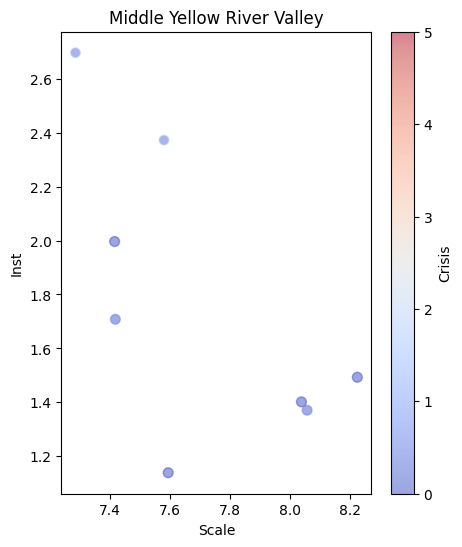

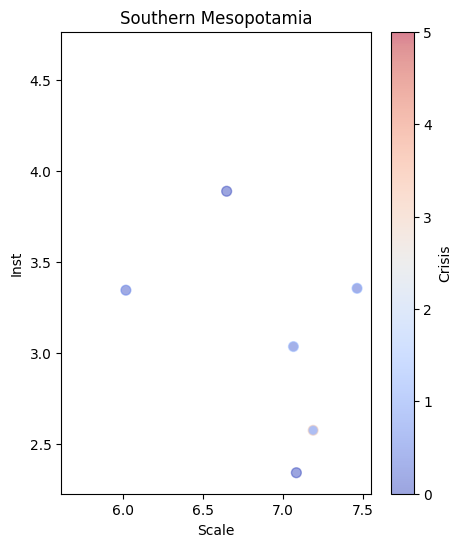

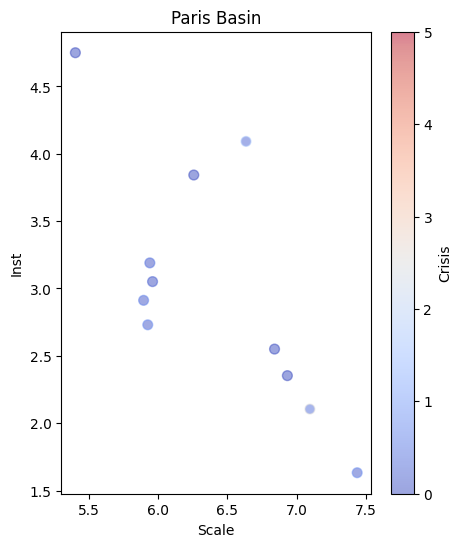

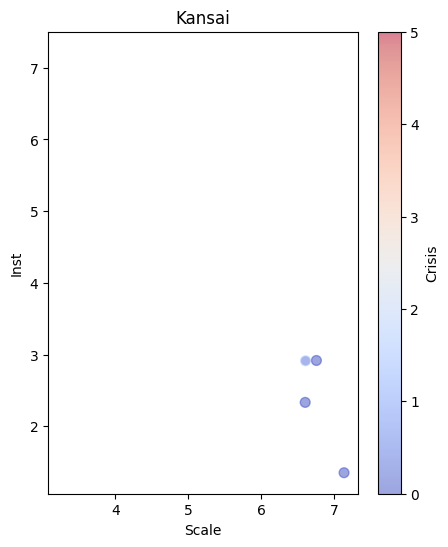

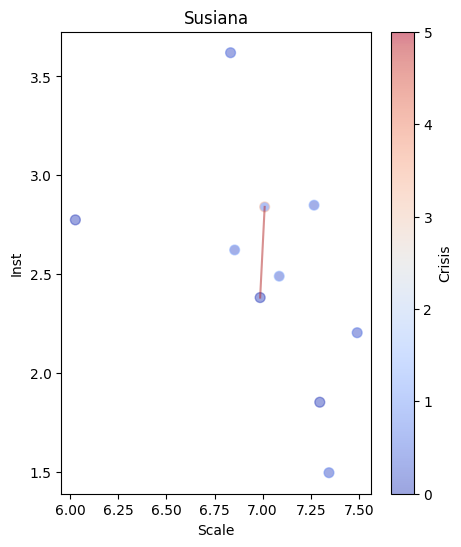

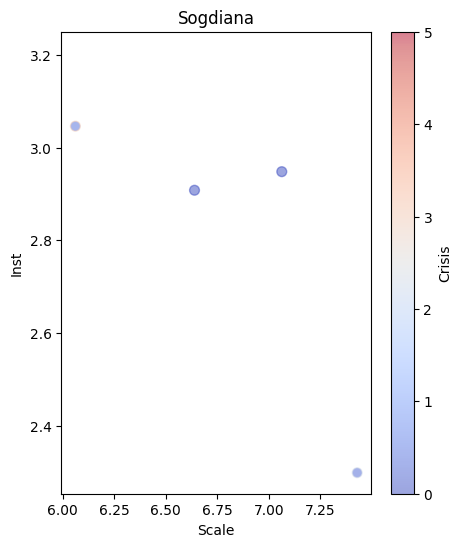

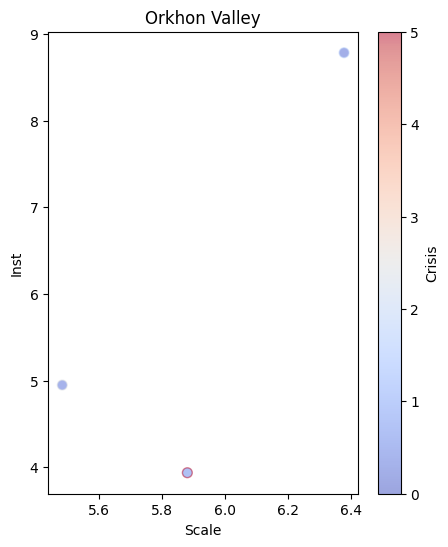

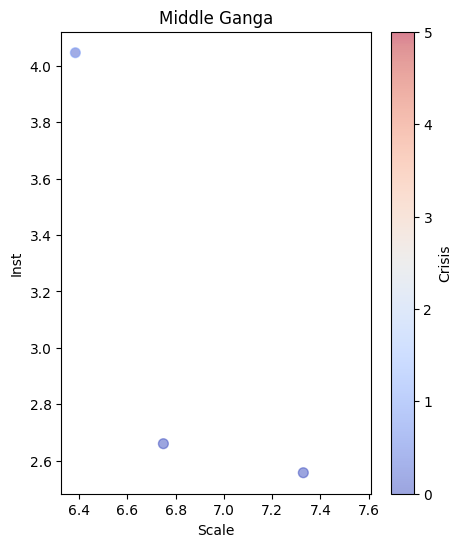

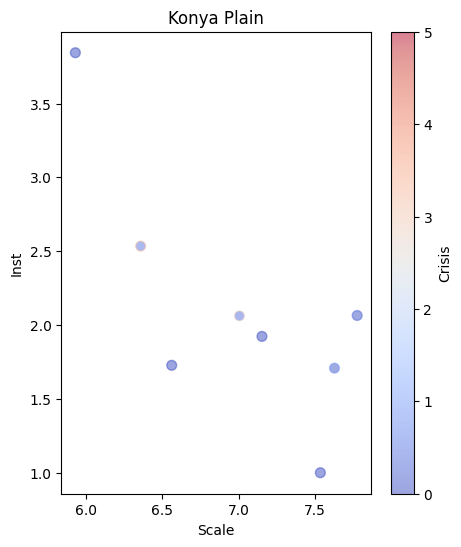

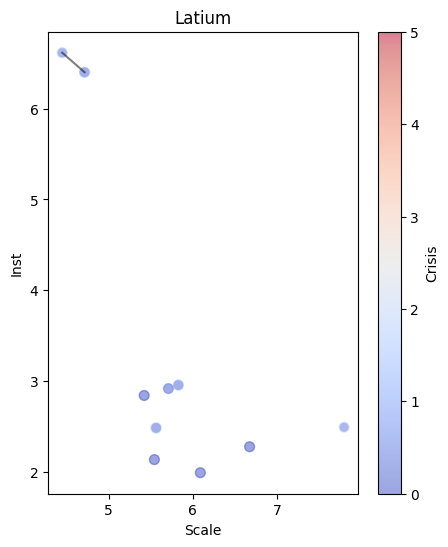

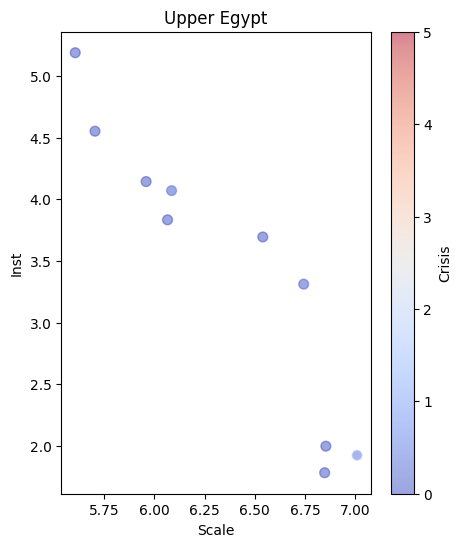

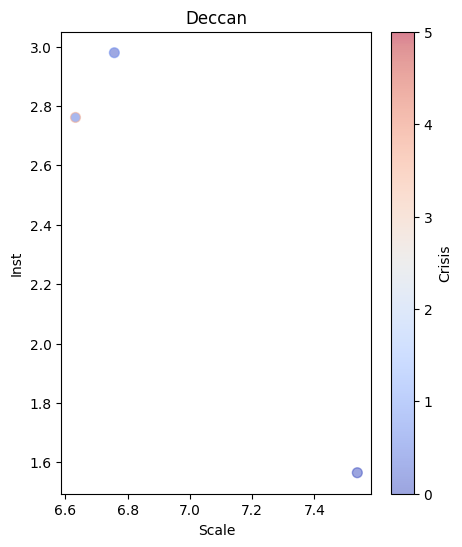

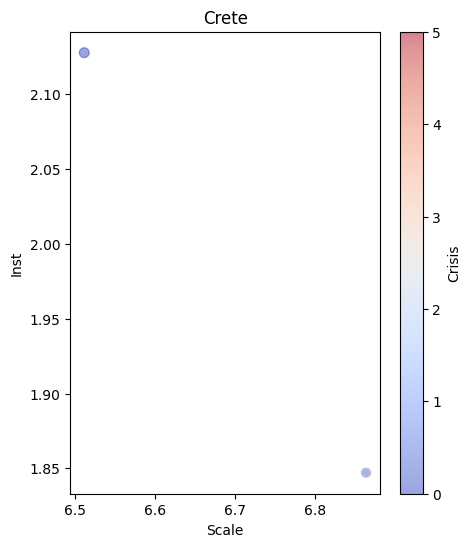

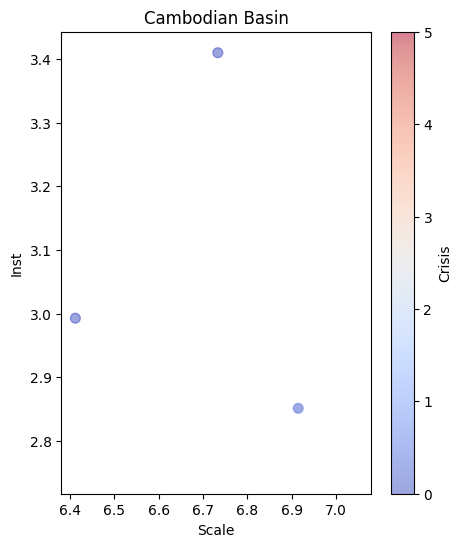

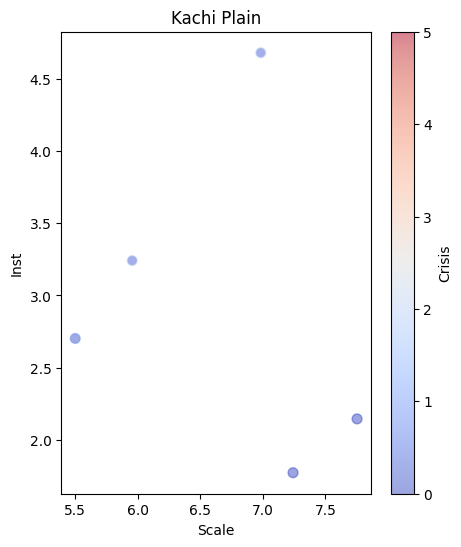

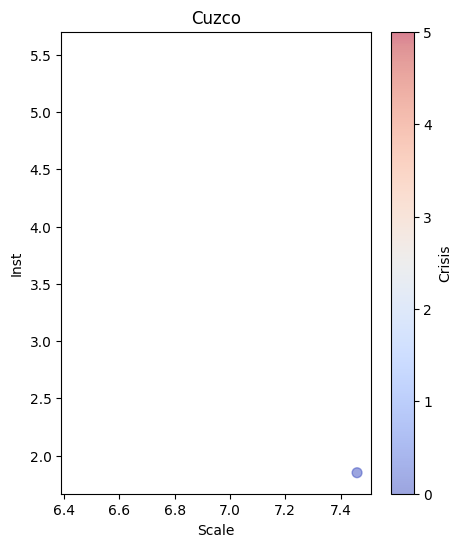

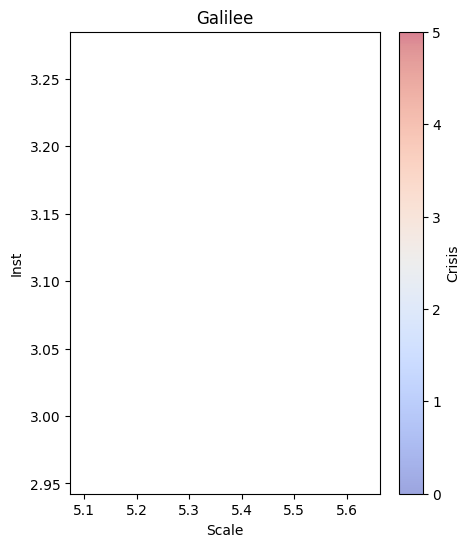

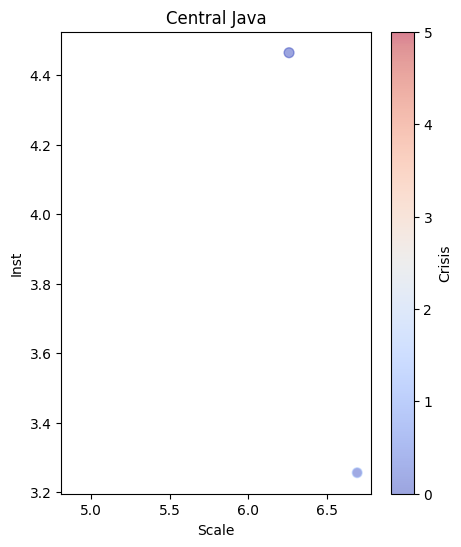

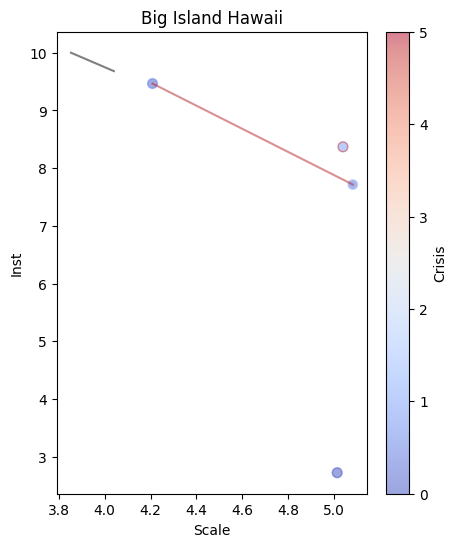

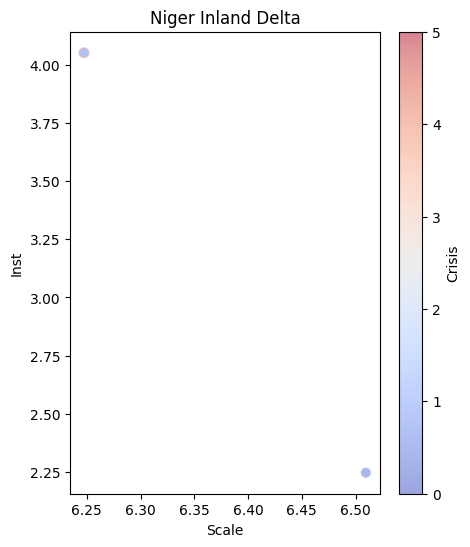

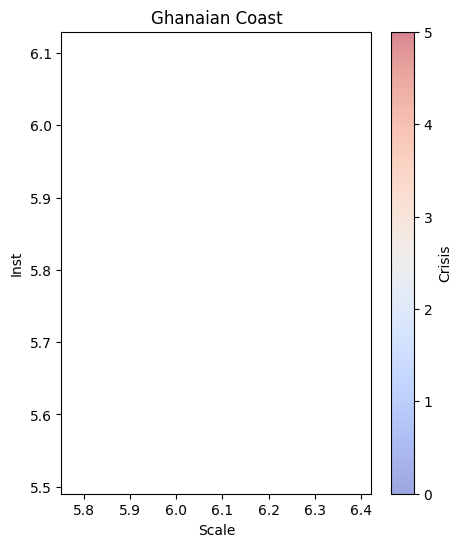

In [79]:
NGAs = dataset_PT.scv_imputed['NGA'].unique()

for nga in NGAs:

    plot_df = dataset_PT.scv_imputed[dataset_PT.scv_imputed['NGA'] == nga]
    if len(plot_df) > 10:                
        fig, ax = plt.subplots(figsize=(5, 6))

        # Create a scatter plot
        scatter = plt.scatter(plot_df['Scale_1'], plot_df['Inst_1'],
                            vmin=0,
                            vmax = 5,
                            c=plot_df['Crisis'],
                            cmap='coolwarm',
                            s=50,
                            alpha=0.5,
                            edgecolors=plt.cm.coolwarm(plot_df['Crisis'] / plot_df['Crisis'].max())
                            )
        for i,pol in enumerate(plot_df['PolityName'].unique()):
            pol_df = plot_df[plot_df['PolityName'] == pol]
            plt.plot(pol_df['Scale_1'], pol_df['Inst_1'], 'k', alpha=0.5)
            if i > 0:
                prev_pol = plot_df[plot_df['PolityName'] == plot_df['PolityName'].unique()[i-1]]
                plt.plot([prev_pol['Scale_1'].iloc[-1], pol_df['Scale_1'].iloc[0]], [prev_pol['Inst_1'].iloc[-1], pol_df['Inst_1'].iloc[0]], 'firebrick', alpha=0.5)
            
        
        # Add a color bar
        plt.colorbar(scatter, label='Crisis')         
        # Show the plot
        plt.title(nga)
        plt.ylabel('Inst')
        plt.xlabel('Scale')
        plt.show()  
    


In [80]:
import pyreadr
dat = pyreadr.read_r("/Users/mperuzzo/Documents/repos/SeshatDatasetAnalysis/datasets/TableData.Rdata")
data = dat['ImpSCDat']
data = data.loc[data.Dupl == 'n']
polity_df = download_data("https://seshatdata.com/api/core/polities/")
polity_df['duration'] = polity_df['end_year'] - polity_df['start_year']

Downloaded 839 rows


In [81]:
old_names = dataset_PT.scv_imputed['PolityName'].apply(lambda x: polity_df.loc[polity_df.new_name == x, "name"].iloc[0] if x in polity_df.new_name.values else np.nan)
to_keep = dataset_PT.scv_imputed.loc[(old_names.isin(data['PolID']))]
to_keep['PolID'] = old_names

/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_90369/673438035.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_keep['PolID'] = old_names


KeyError: 'Column not found: PolityDuration'

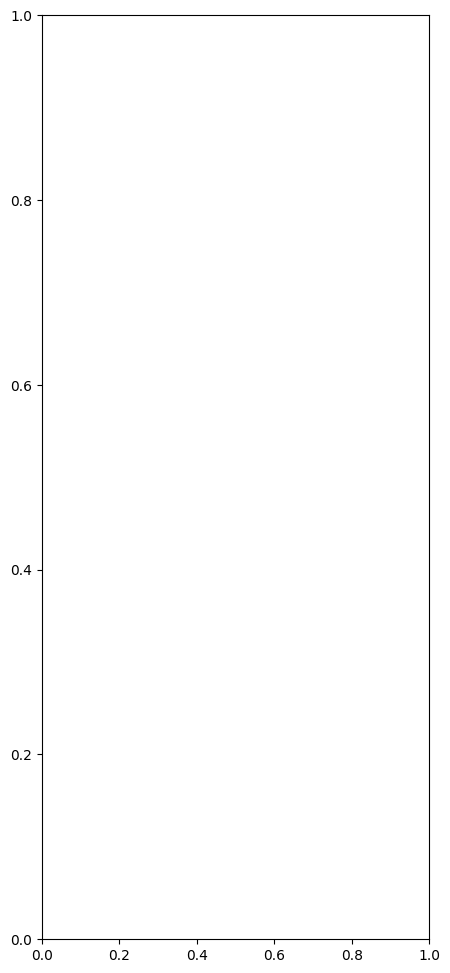

In [82]:
import matplotlib.pyplot as plt

polity_group = to_keep.groupby('PolID')
fig, ax = plt.subplots(figsize=(5, 12))
# Assuming polity_group is a DataFrame or GroupBy object
mean_inst_1 = polity_group['Inst_1'].mean()
mean_scale_1 = polity_group['Scale_1'].mean()
mean_crisis = polity_group['Crisis'].mean()
num_observations = polity_group.size()
duration = polity_group['PolityDuration'].mean()


threshold = 0.0
if threshold > 0:
    mean_inst_1 = mean_inst_1.loc[mean_crisis > threshold]
    mean_scale_1 = mean_scale_1.loc[mean_crisis > threshold]
    num_observations = num_observations[mean_crisis > threshold]
    duration = duration[mean_crisis > threshold]
    mean_crisis = mean_crisis.loc[mean_crisis > threshold]
    old_names = old_names.loc[old_names.isin(mean_crisis.index)]


v_max = 0.6 # mean_crisis.max()*.75
# Create a scatter plot
scatter = plt.scatter(mean_scale_1, mean_inst_1,
                      vmin = 0,
                      vmax = v_max,
                      c=mean_crisis,
                      cmap='jet',
                      s=num_observations * 5,
                      alpha=0.8,
                      edgecolors=plt.cm.jet(mean_crisis / v_max)
                      )

# Add a color bar
plt.colorbar(scatter, label='Crisis')
# add name of polity on each bubble
for i, txt in enumerate(mean_crisis.index):

    ax.annotate(txt, (mean_scale_1[i]-0.5, mean_inst_1[i]+0.1), fontsize=6)

# Show the plot
plt.ylabel('Inst')
plt.xlabel('Scale')
plt.show()


In [ ]:
new_pols = to_keep.PolID.unique()
old_pols = data.PolID.unique()
common_polities = np.intersect1d(new_pols, old_pols)

col_dict = {'Gov':'Government', 'Infra':'Infrastructure', 'Info':'Information', 'Hier':'Hierarchy'}
data.rename(columns=col_dict, inplace=True)
relevant_cols = ['Pop','Terr','Cap','Hierarchy','Government','Infrastructure','Information','MSP']
diffs = np.zeros((len(common_polities), len(relevant_cols)))

for pol in common_polities:
    new_pol = to_keep.loc[to_keep.PolID == pol]
    old_pol = data.loc[data.PolID == pol]
    for col in relevant_cols:
        diff = new_pol[col].mean() - old_pol[col].mean()
        if pd.isna(new_pol[col].mean()) and pd.isna(old_pol[col].mean()):
            diff = 0
        diffs[np.where(common_polities == pol)[0][0], relevant_cols.index(col)] = diff

In [ ]:
plt.pcolor(diffs, cmap='coolwarm')
plt.clim(-10,10)
plt.xticks(np.arange(0.5, len(relevant_cols), 1), relevant_cols, rotation=45)
# remove yticks
plt.yticks([])
plt.ylabel('Polities')

plt.colorbar()